[1] loss: 19075.141


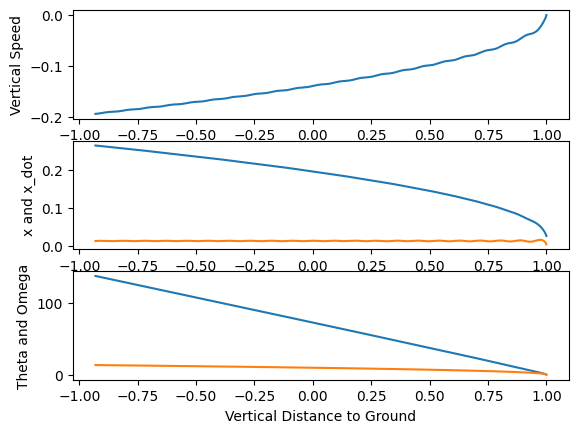

[2] loss: 4553.943


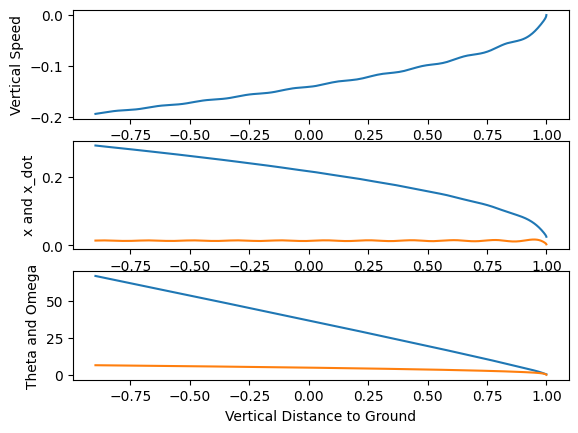

[3] loss: 1265.179


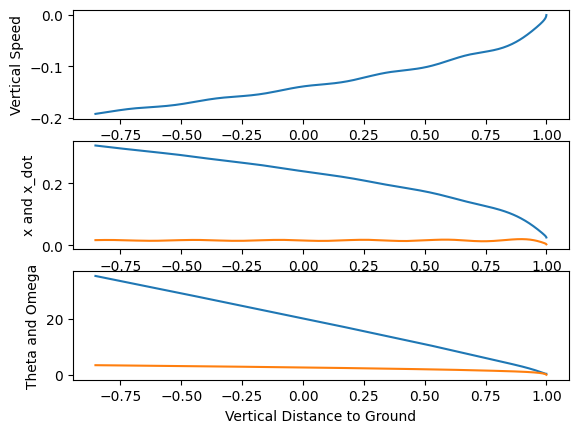

[4] loss: 351.763


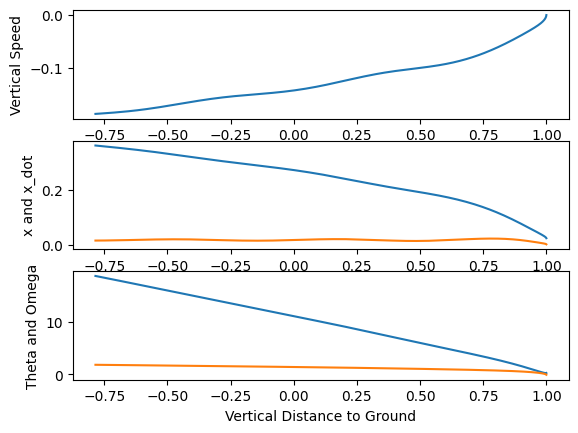

[5] loss: 93.463


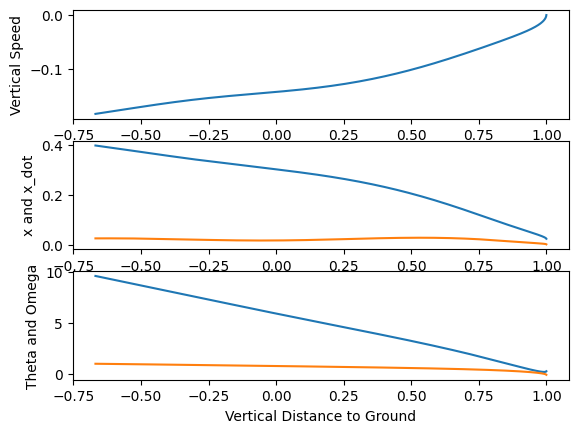

[6] loss: 23.712


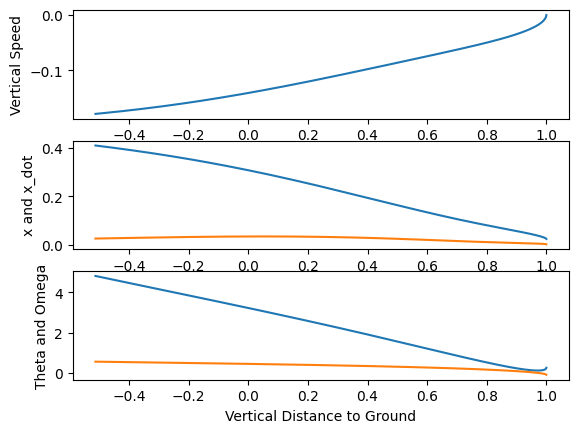

[7] loss: 5.607


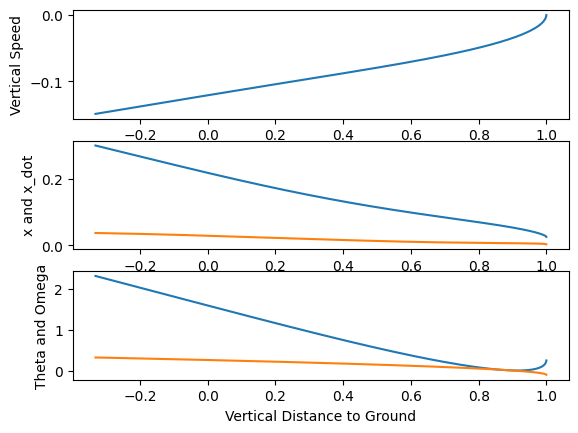

[8] loss: 1.253


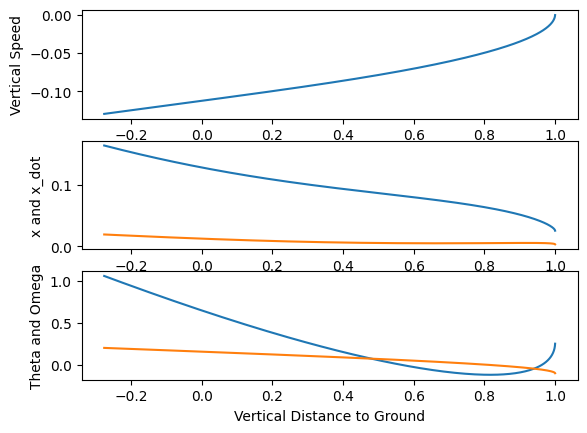

[9] loss: 0.303


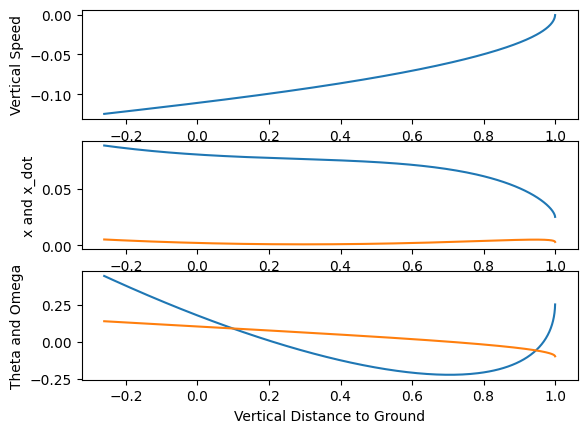

[10] loss: 0.108


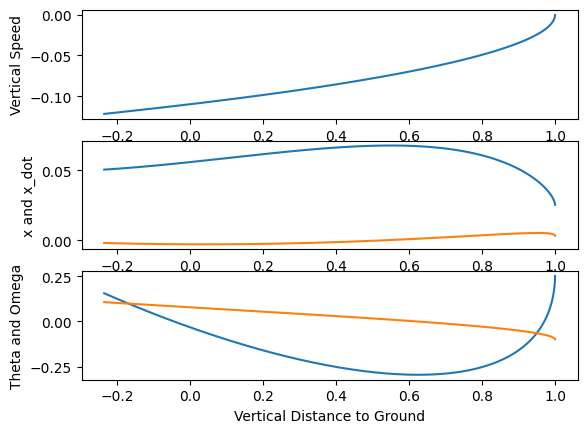

[11] loss: 0.058


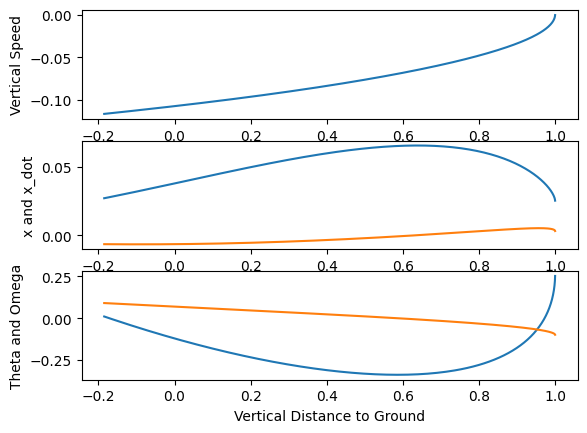

[12] loss: 0.028


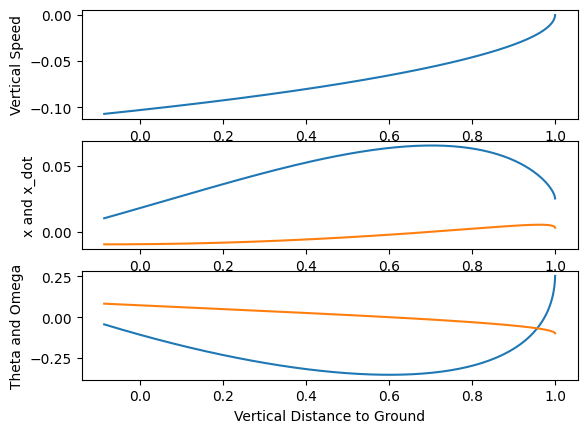

[13] loss: 0.018


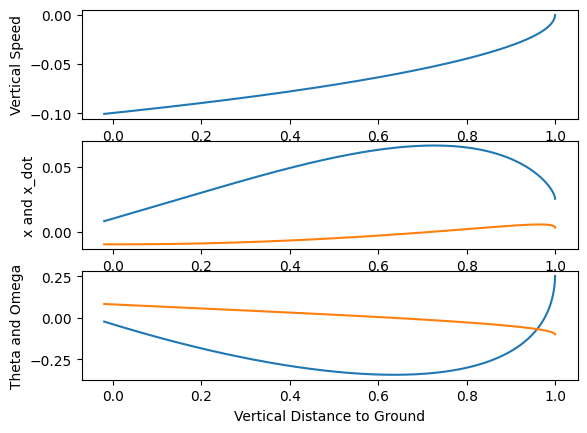

[14] loss: 0.017


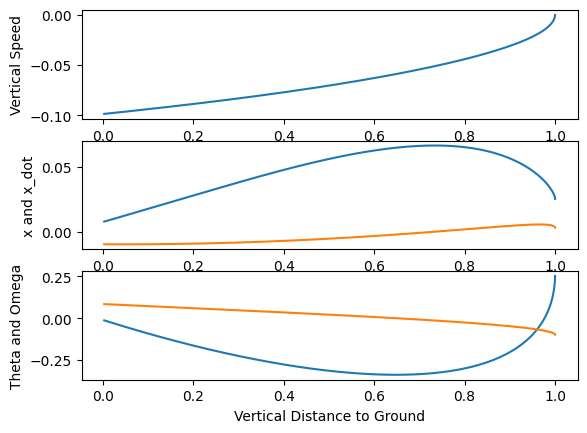

[15] loss: 0.017


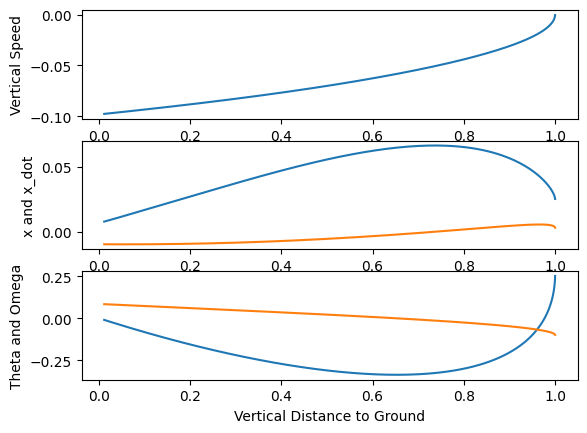

[16] loss: 0.017


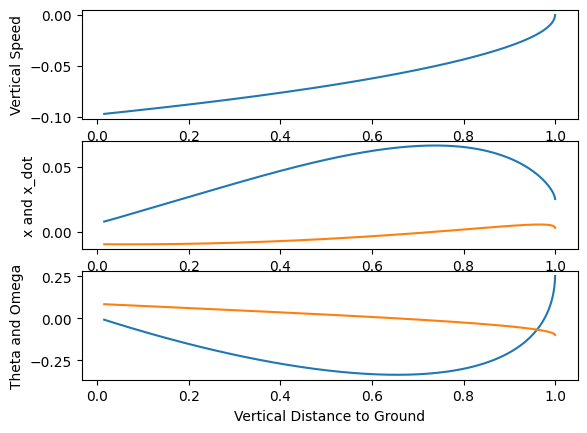

[17] loss: 0.017


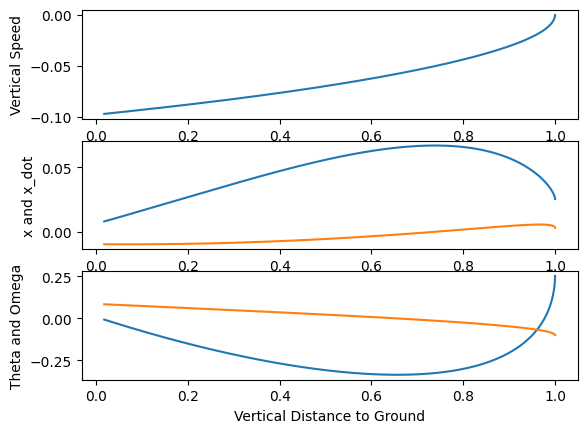

[18] loss: 0.017


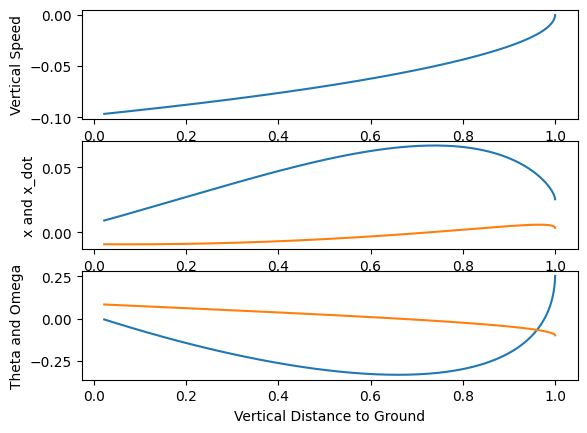

[19] loss: 0.016


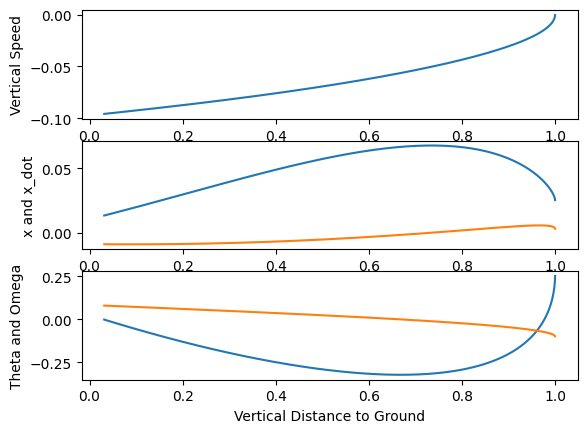

[20] loss: 0.014


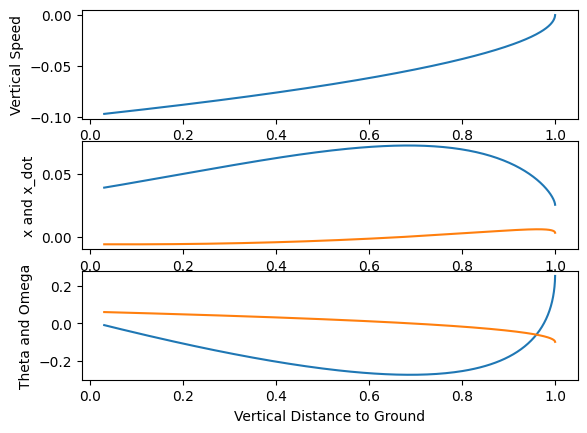

[21] loss: 0.013


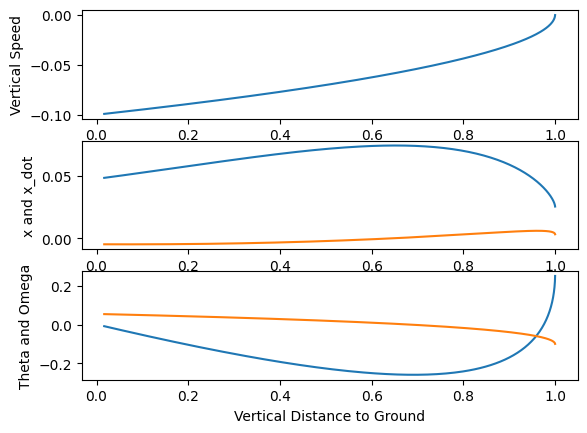

[22] loss: 0.012


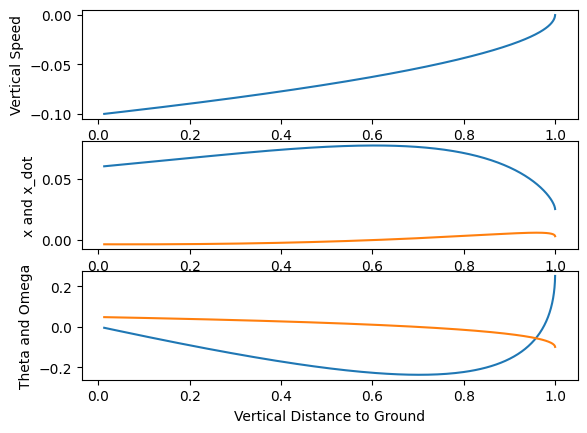

[23] loss: 0.012


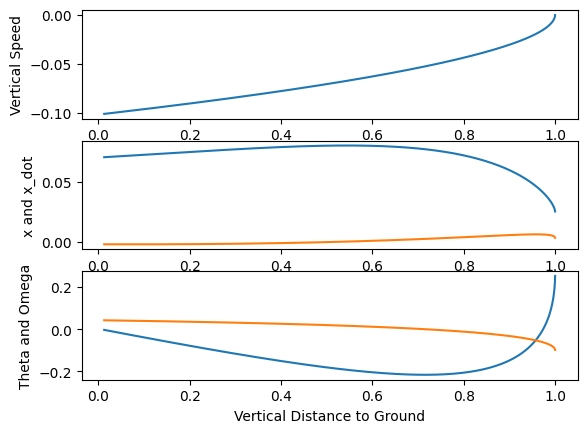

[24] loss: 0.012


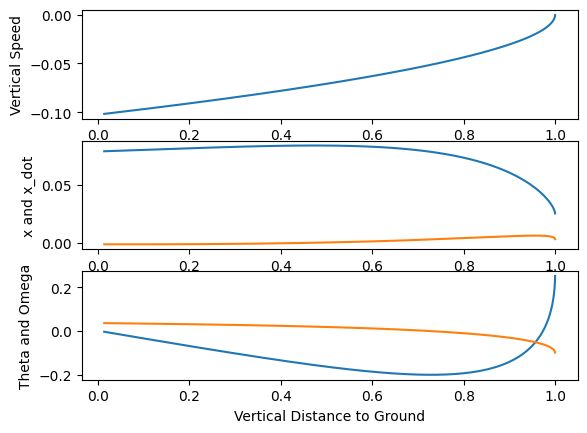

[25] loss: 0.011


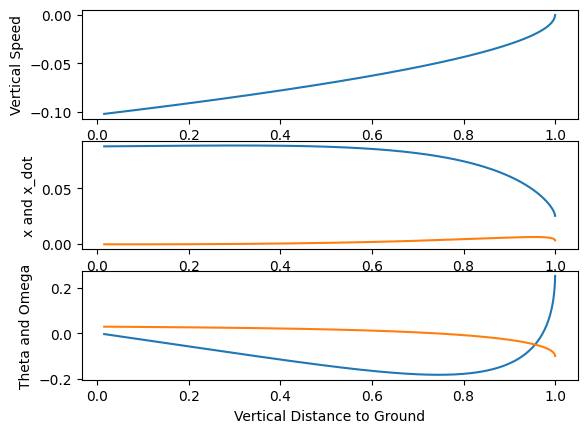

[26] loss: 0.011


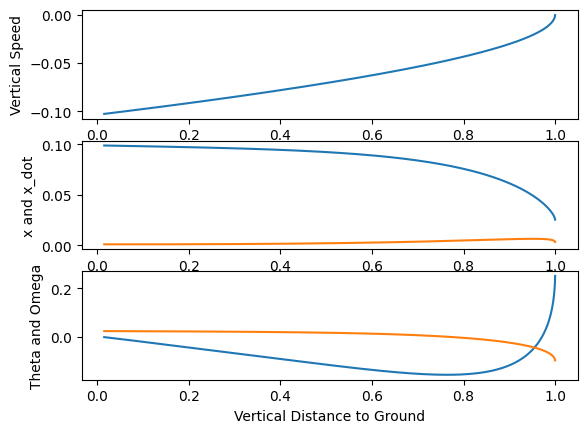

[27] loss: 0.011


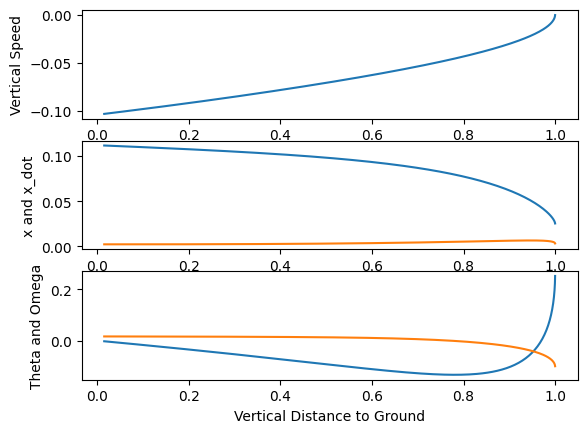

[28] loss: 0.011


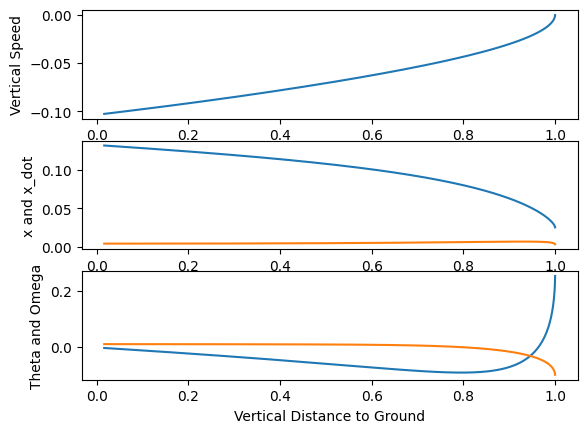

[29] loss: 0.009


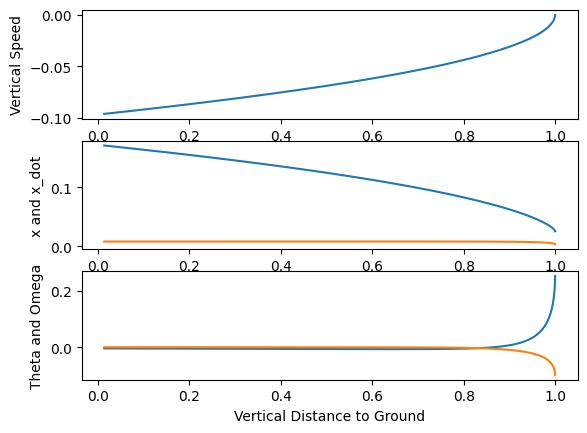

[30] loss: 0.008


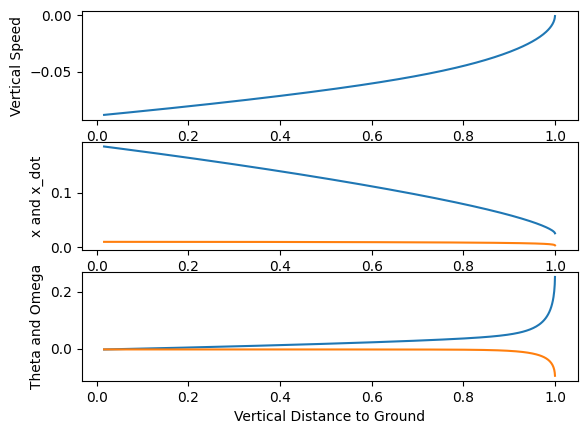

[31] loss: 0.006


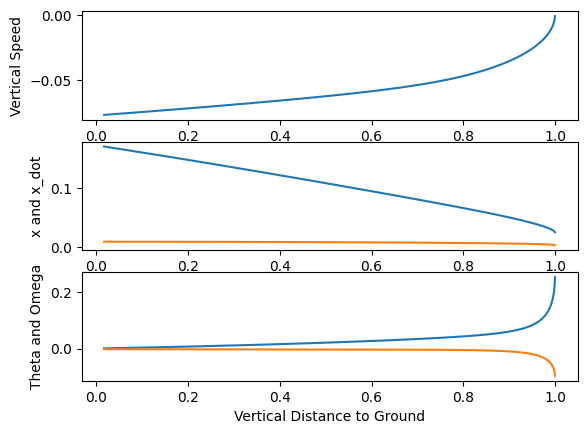

[32] loss: 0.005


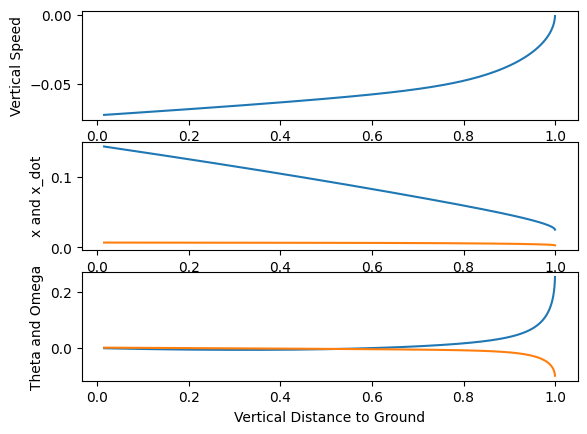

[33] loss: 0.005


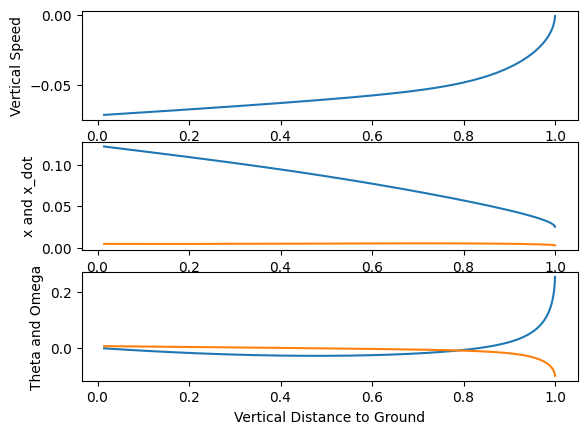

[34] loss: 0.005


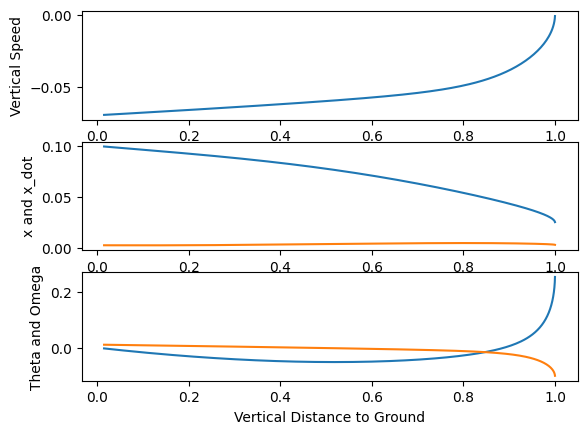

[35] loss: 0.005


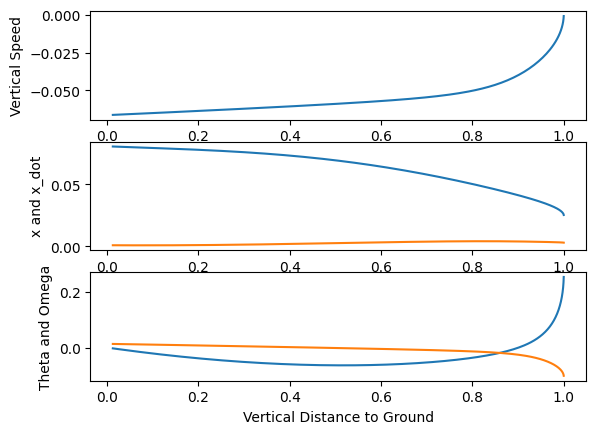

[36] loss: 0.019


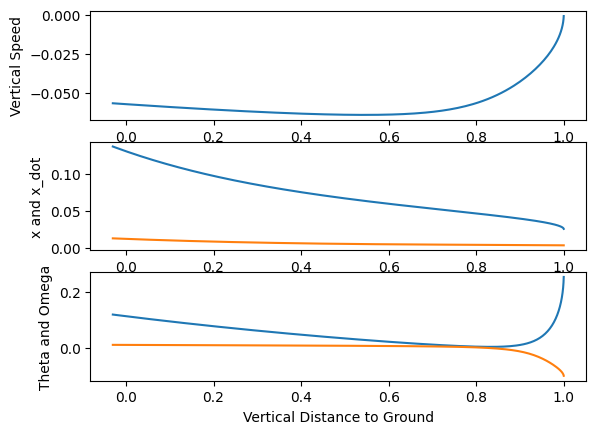

[37] loss: 0.003


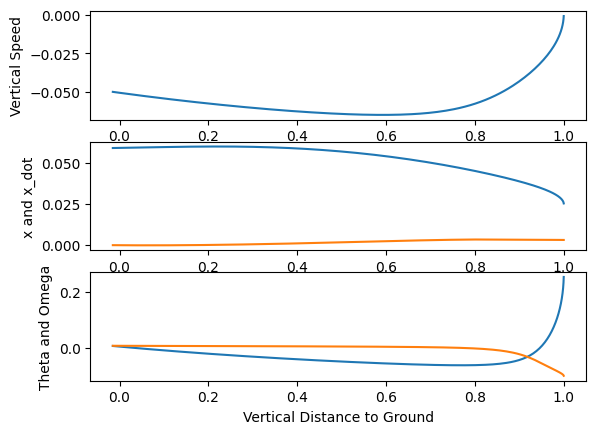

[38] loss: 0.002


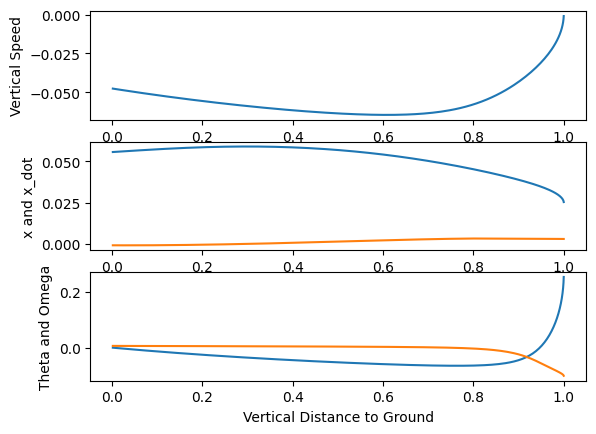

[39] loss: 0.002


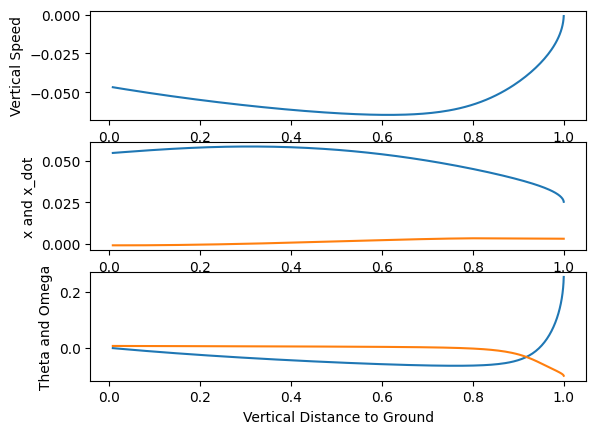

[40] loss: 0.002


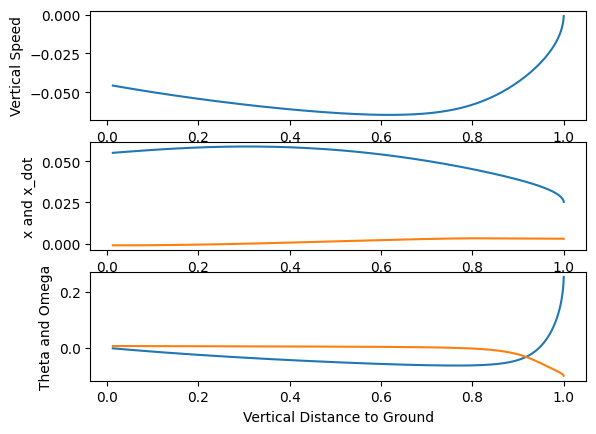

[41] loss: 4.024


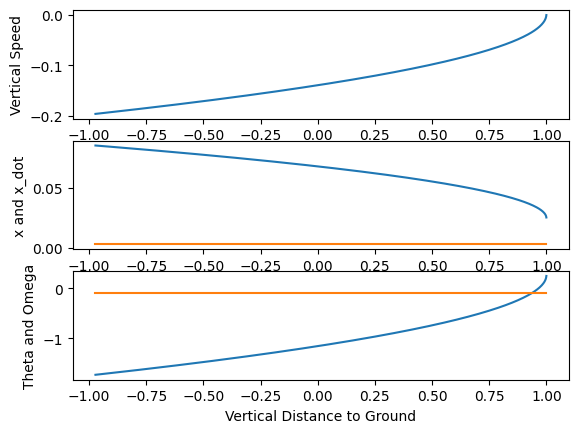

[42] loss: 4.024


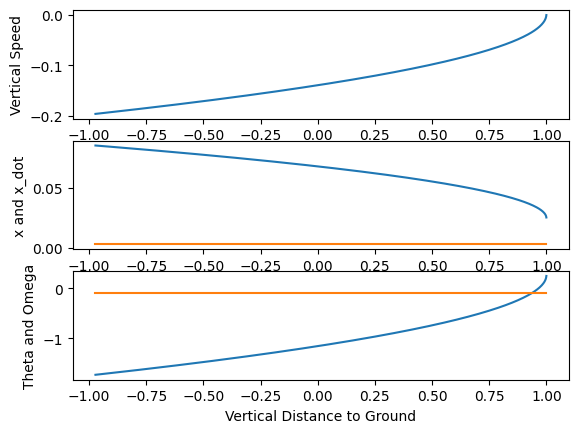

[43] loss: 4.024


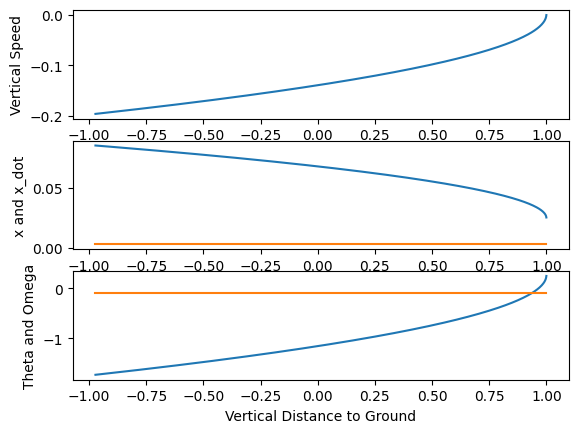

[44] loss: 4.024


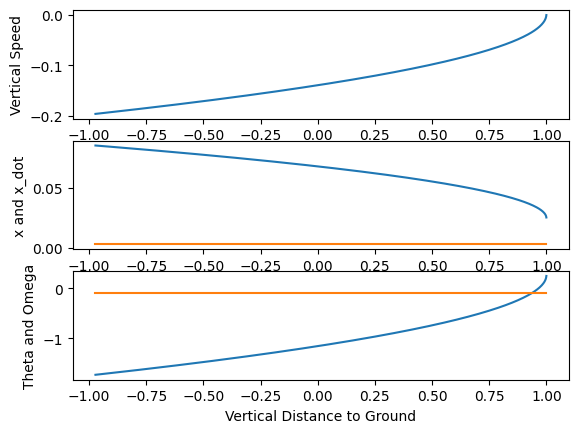

[45] loss: 4.024


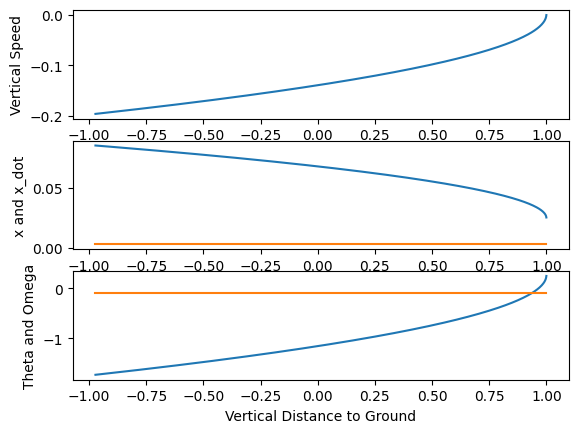

[46] loss: 4.024


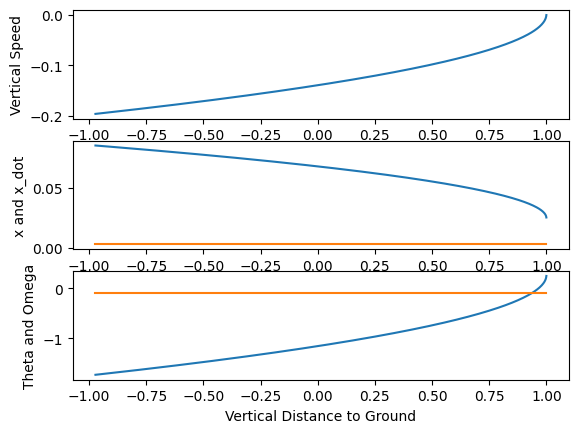

[47] loss: 4.024


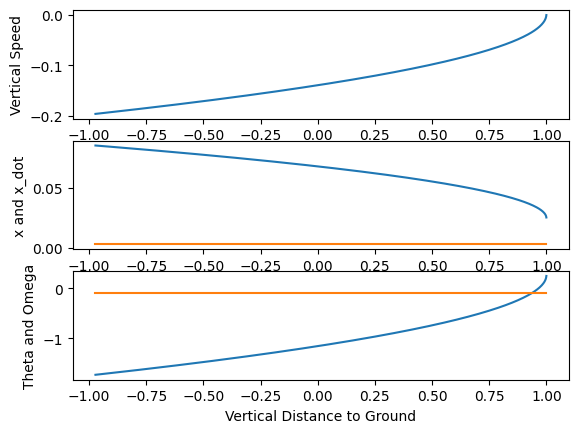

[48] loss: 4.024


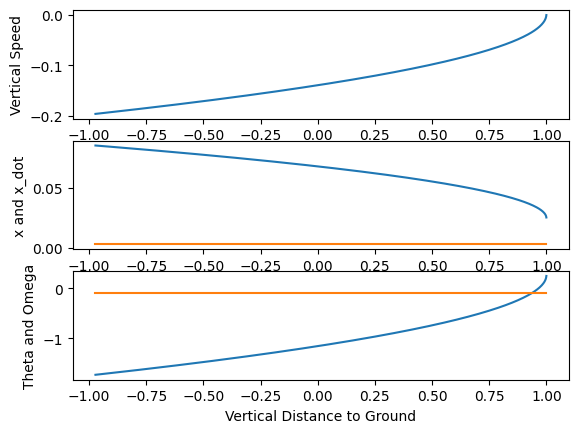

[49] loss: 4.024


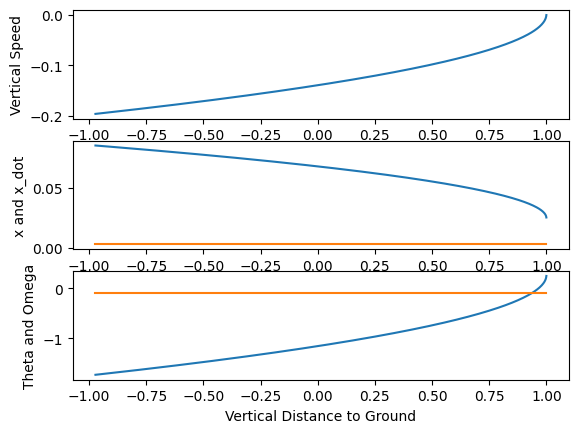

[50] loss: 4.024


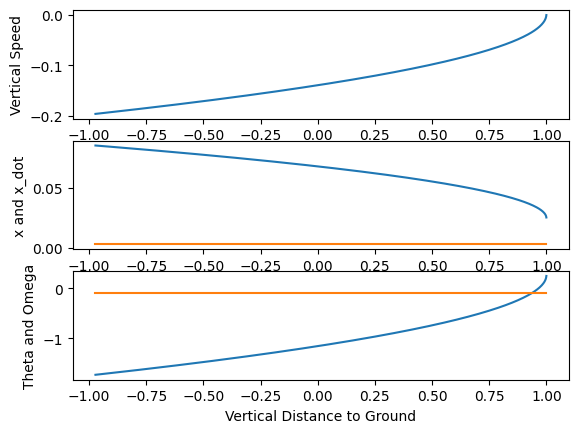

[51] loss: 4.024


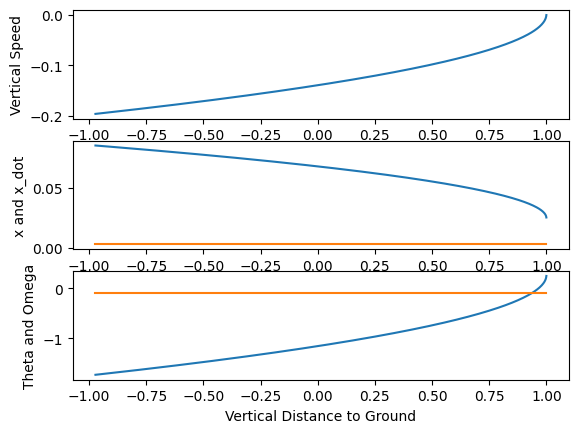

[52] loss: 4.024


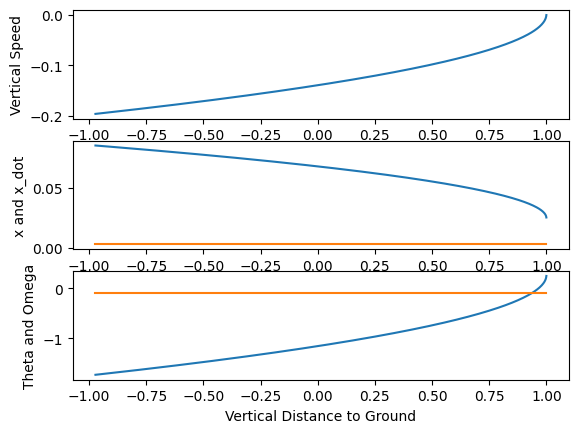

[53] loss: 4.024


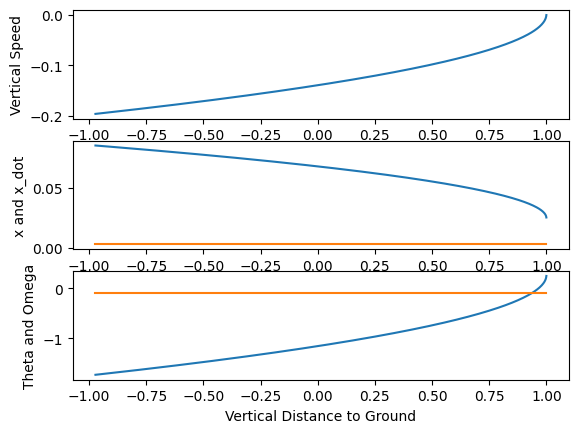

[54] loss: 4.024


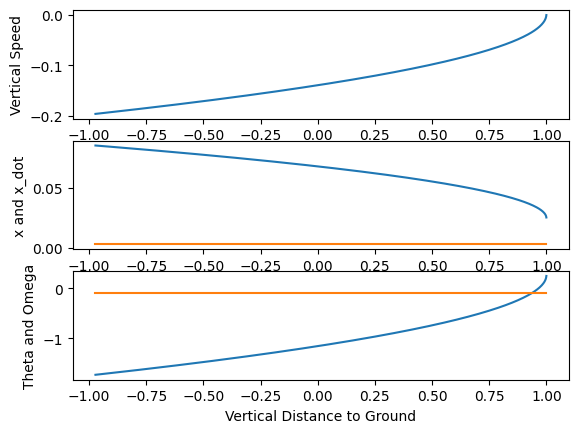

[55] loss: 4.024


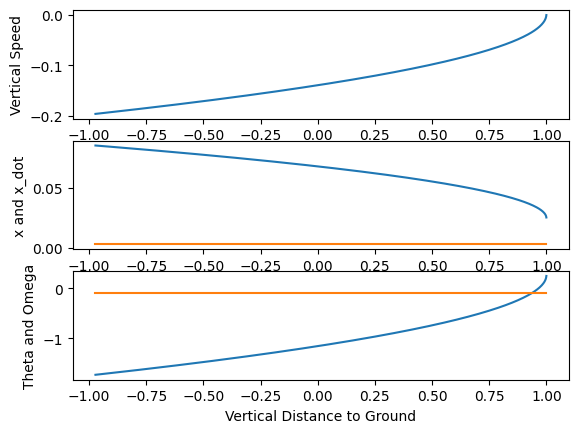

[56] loss: 4.024


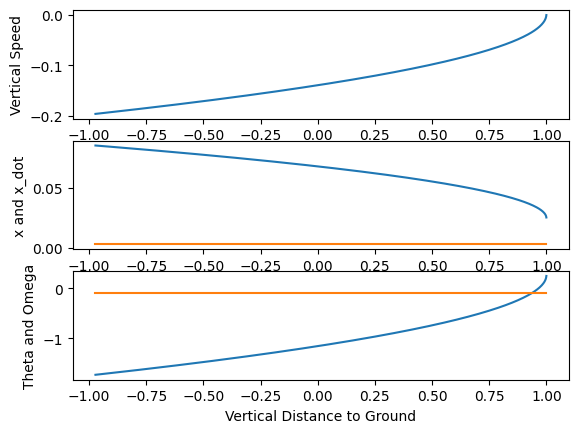

[57] loss: 4.024


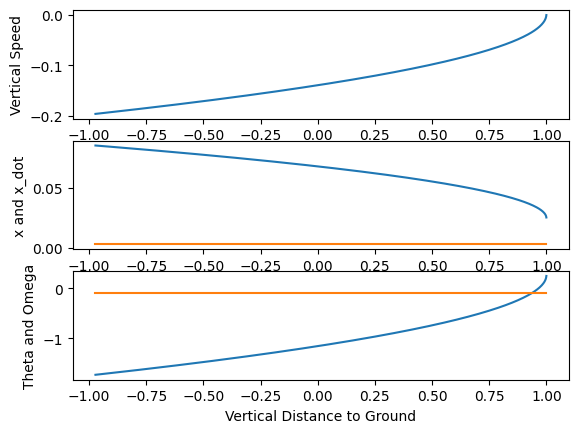

[58] loss: 4.024


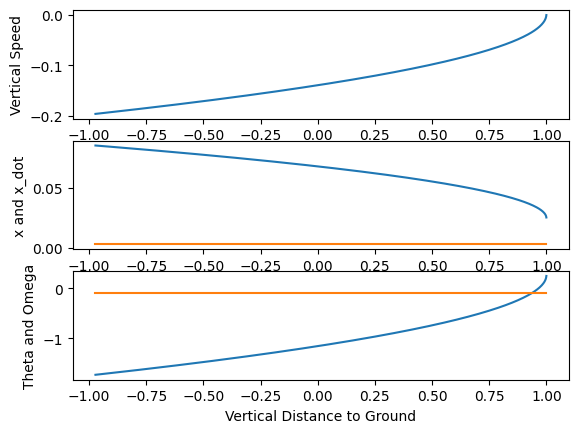

[59] loss: 4.024


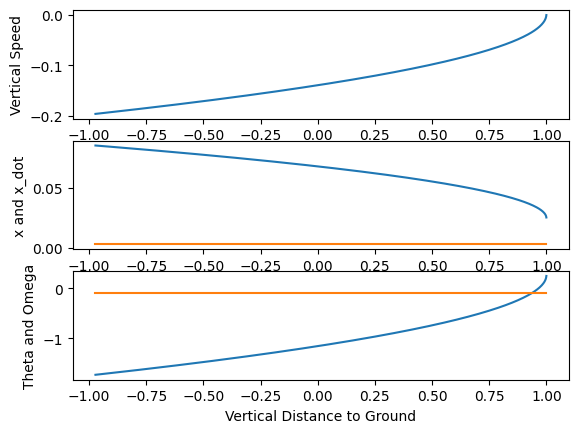

[60] loss: 4.024


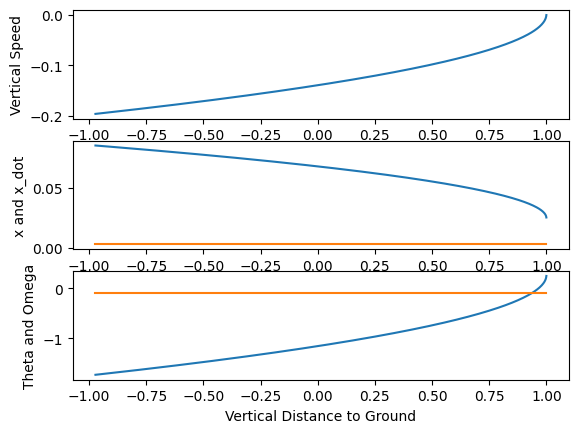

[61] loss: 4.024


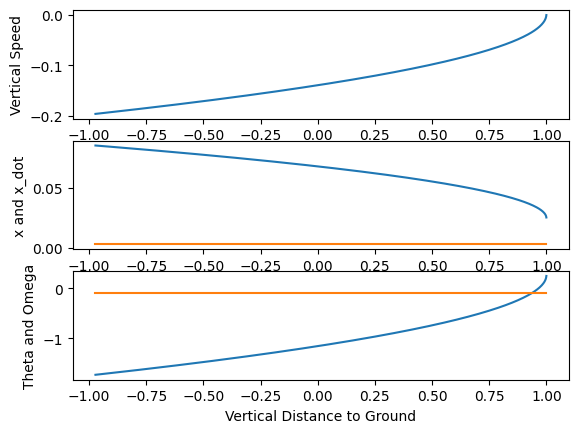

[62] loss: 4.024


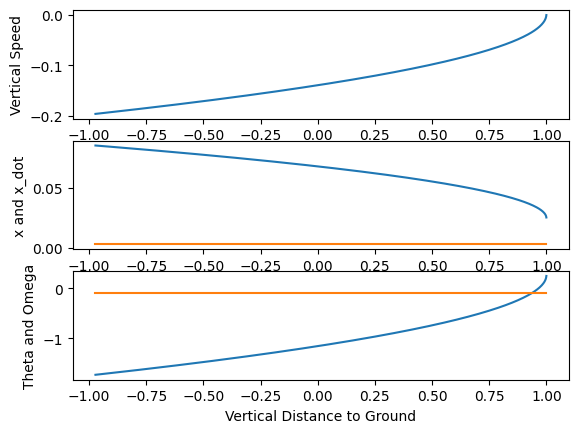

[63] loss: 4.024


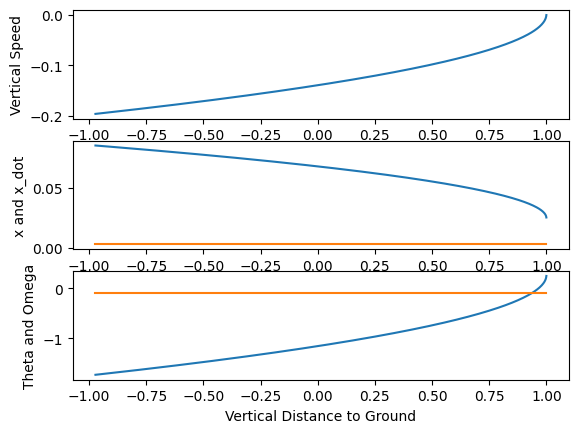

[64] loss: 4.024


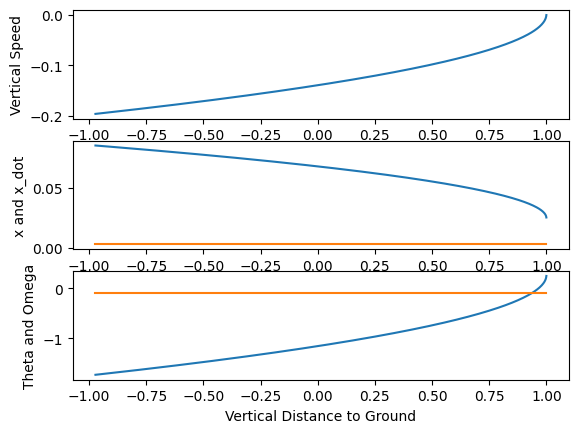

[65] loss: 4.024


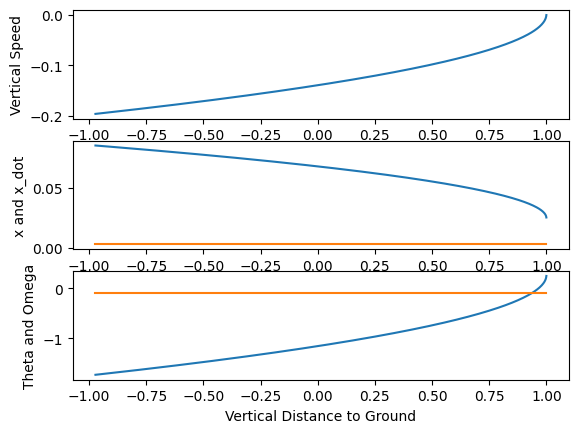

[66] loss: 4.024


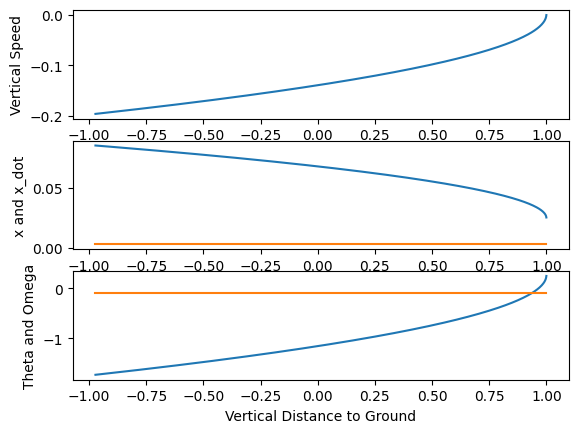

[67] loss: 4.024


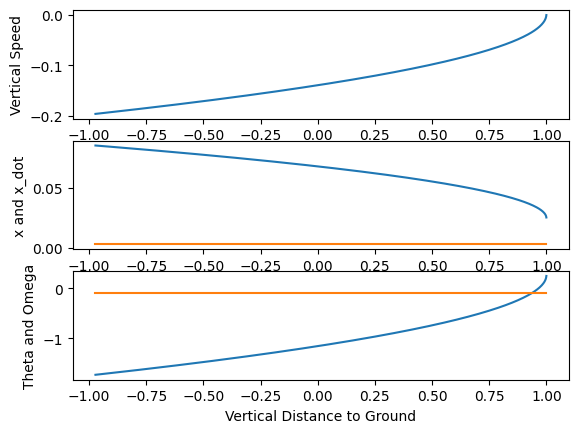

[68] loss: 4.024


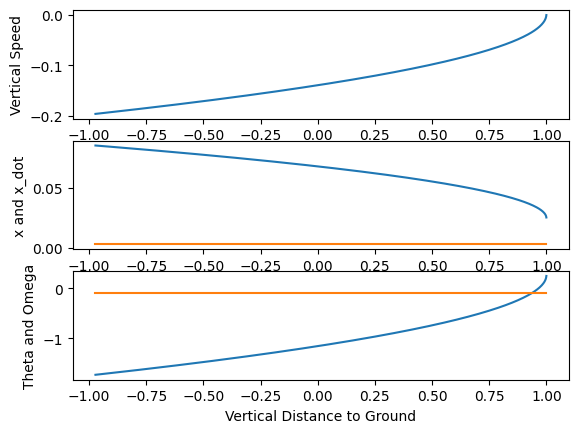

[69] loss: 4.024


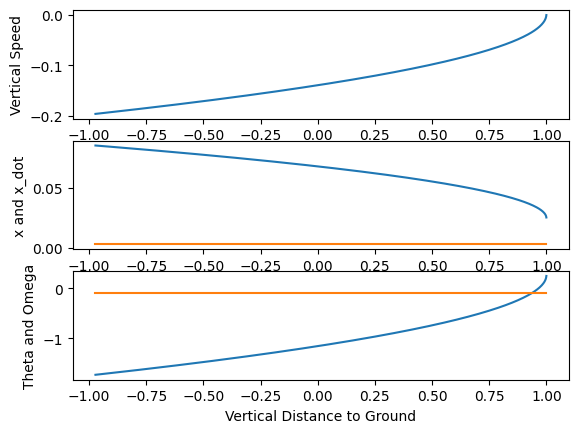

[70] loss: 4.024


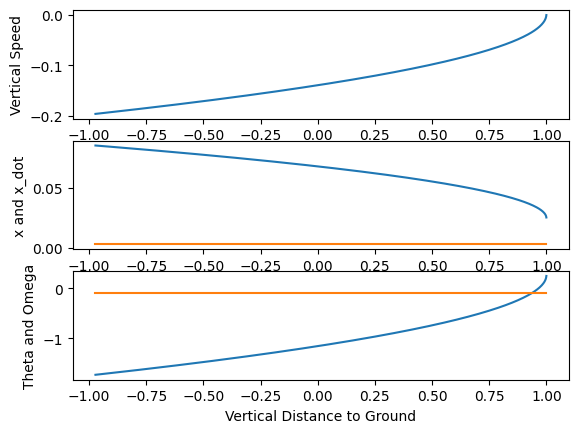

[71] loss: 4.024


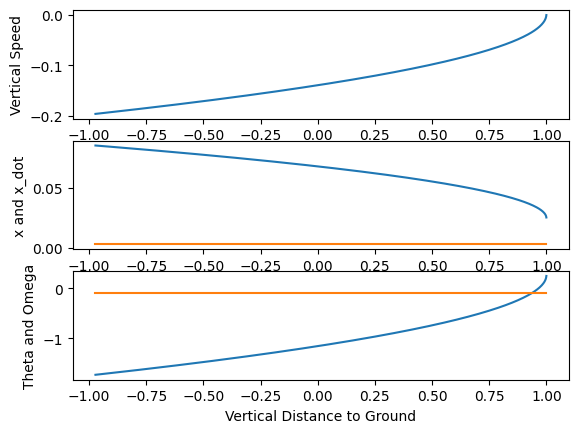

[72] loss: 4.024


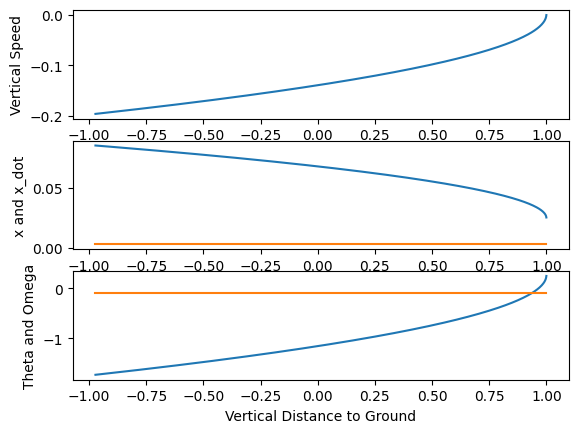

[73] loss: 4.024


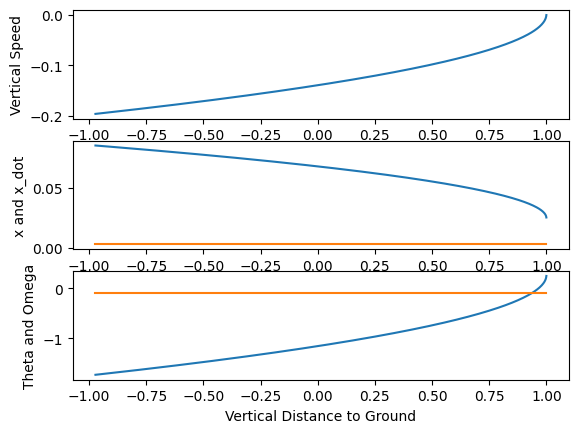

[74] loss: 4.024


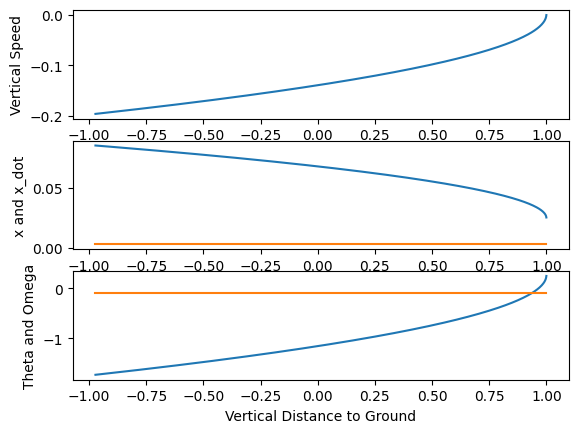

[75] loss: 4.024


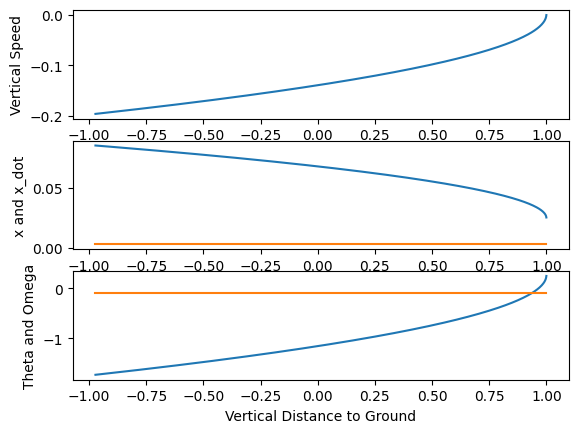

[76] loss: 4.024


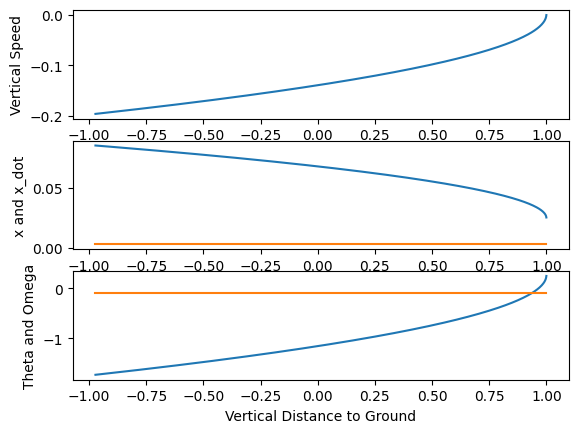

[77] loss: 4.024


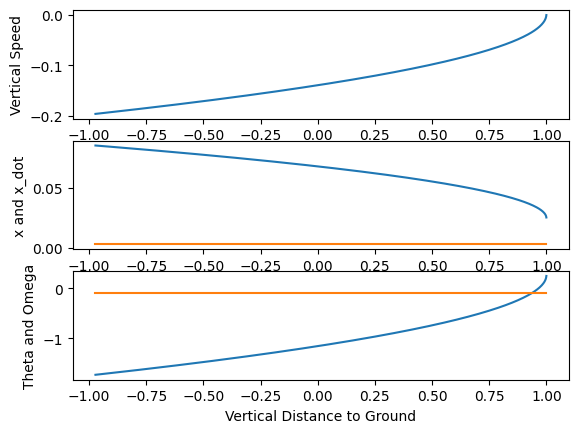

[78] loss: 4.024


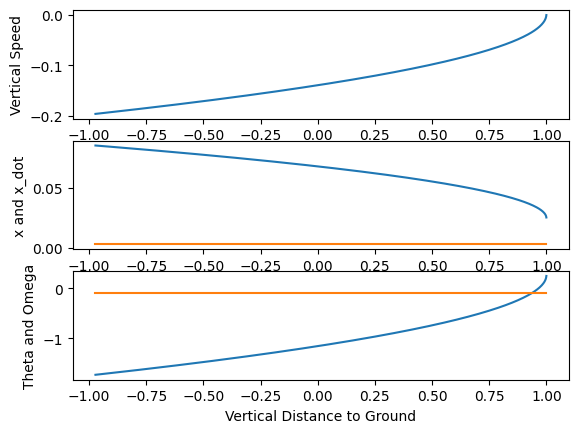

[79] loss: 4.024


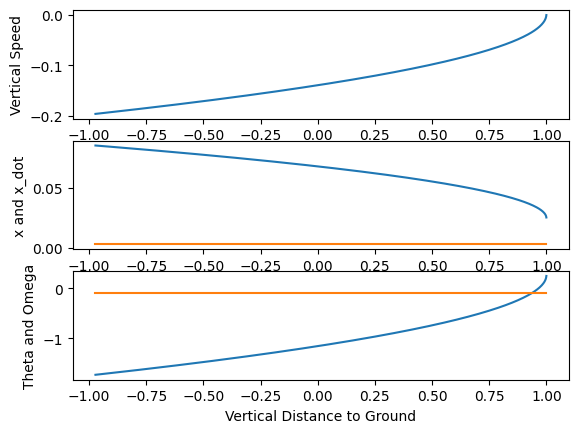

[80] loss: 4.024


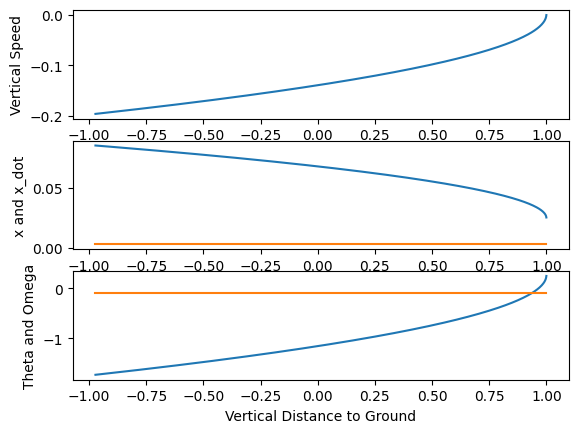

In [15]:
import logging
import math
import random
import numpy as np
import time

import torch
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

FRAME_TIME = 0.1
GRAVITY_ACCEL = 9.81 / 1000
BOOST_ACCEL = 14.715 / 1000
L_center_of_gravity = 5 / 1000

PLATFORM_WIDTH = 25 / 1000

class Dynmaics(nn.Module):

    def __init__(self):
        super(Dynmaics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0]: thrust
        action[1]: phi of thrust
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        state[4] = theta
        state[5] = omega
        """
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0., 0., 0., 0])

        #Thrust and omega Calculations
        state_tensor = torch.zeros((6,2))
        state_tensor[1, 0] = torch.cos(state[4] + action[1])
        state_tensor[3, 0] = torch.sin(state[4] + action[1])
        state_tensor[5, 1] = 4 / L_center_of_gravity * t.sin(action[1]) * action[0]
        delta_state_thrust = BOOST_ACCEL * FRAME_TIME * torch.matmul(action, t.t(state_tensor))

        state = state + delta_state_thrust + delta_state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 0., 0., 1]])
        state = t.t(t.matmul(step_mat, state.t()))

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to me
        """

        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid(),
            nn.Linear(dim_output, dim_input),
            nn.ELU(),
            nn.Linear(dim_input, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state, self.state_trajectory)

    @staticmethod
    def initialize_state():
        state = [1., 0., .025, .003, 15 * math.pi / 180, -0.1] # need initial conditions
        return t.tensor(state, requires_grad=False).float()

    def error(self, state, state_trajectory):
        termination_error = (state[0] - L_center_of_gravity)**2 + state[1]**2 + state[3]**2 + state[4]**2 + state[5]**2
        #boolean = state_trajectory[:, 0] <= 0
        #boolean = 1 * boolean
        #transient_error = t.matmul( t.transpose(boolean, 0, 1), state_trajectory[:,1]) **2
        return termination_error

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.05)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y = data[:, 0]
        y_dot = data[:, 1]
        x = data[:, 2]
        x_dot = data[:,3]
        theta = data[:,4]
        omega = data[:, 5]
        fig, axs = plt.subplots(3,1)
        axs[0].plot(y, y_dot)
        axs[0].set_xlabel('Vertical Distance to Ground')
        axs[0].set_ylabel('Vertical Speed')
        axs[1].plot(y, x, label='Horizontal Distance from Platform')
        axs[1].plot(y, x_dot, label='Horizontal Speed')
        axs[1].set_xlabel('Vertical Distance to Ground')
        axs[1].set_ylabel('x and x_dot')
        axs[2].plot(y, theta, label='Orientation')
        axs[2].plot(y, omega, label='Angular Speed')
        axs[2].set_xlabel('Vertical Distance to Ground')
        axs[2].set_ylabel('Theta and Omega')
        plt.show()
        plt.legend


T = 200
dim_input = 6
dim_hidden = 24
dim_output = 2
d = Dynmaics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(80)
